In [2]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [3]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [4]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [5]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [6]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.001, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

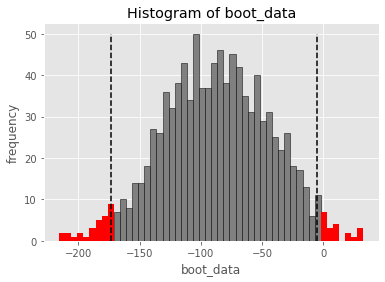

In [7]:
booted_data = get_bootstrap(df.sample_1, df.sample_2) # в результате хранится разница двух распределений, ДИ и pvalue

In [8]:
booted_data["p_value"] # альфа

0.04564731158962379

In [9]:
booted_data["quants"] # ДИ

,0
0.025,-173.270058
0.975,-4.865217


Описание эксперимента : перед нами таблица с результатми А/Б теста. В числовой колонке показана выручка по каждому пользователю за период эксперимента

Описание колонок : value - значения метрики, experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

Задача : Нужно понять, стали ли мы больше зарабатывать с пользователя или нет ?
    - Считаем  p-value тремя способами: t-тест, U-тест, бутстрап средних
    - Сравниваем результат между тестом и контролем по всем этим кейсам
    - Делаем выводы

Формируем гипотезы : Но - стат значимых различий по средней выручке в контрольной  и тестовой группах нет
                     Н1 - разлиячиия есть

In [10]:
data = pd.read_csv('hw_bootstrap.csv', encoding='Utf-8', sep = ';', decimal=',')

In [11]:
data

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control
...,...,...,...
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment


In [10]:
# Посмотрим на размер наших выборок : Control и Treatment

In [12]:
data.groupby('experimentVariant', as_index=False).agg({'value': 'count'})

,experimentVariant,value
0,Control,500
1,Treatment,500


In [47]:
# Посчитаем среднее и медиану в наших группах

In [13]:
data.groupby('experimentVariant', as_index=False).agg({'value': 'mean'}) # cчитаем среднее

,experimentVariant,value
0,Control,10.026867
1,Treatment,27.321499


In [14]:
data.groupby('experimentVariant', as_index=False).agg({'value': 'median'}) #считаем медиану

,experimentVariant,value
0,Control,10.018465
1,Treatment,10.025847


Уже видно, что средняя выручка в тестовой группе значительно превышает медиану. 
Это может говорить нам о наличии значительных выбросов в этой группе.
Построим боксплот график

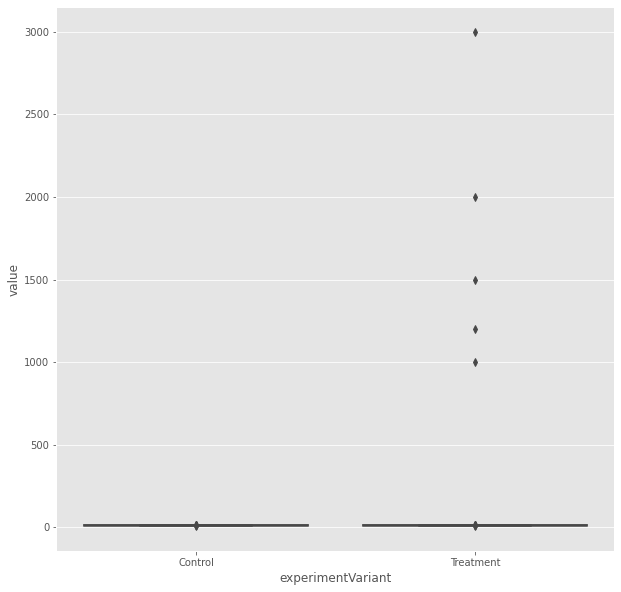

In [15]:
plt.figure(figsize=(10, 10))
ax = sns.boxplot(x="experimentVariant", y="value", data=data)


Как и предполагалось, в тестовой выборке(Treatment) у нас есть значения, которые лежат очень далеко от средних значений, поэтому наш боксплот не вышел.
Прологорифмируем значения выручки и заново построим график

In [16]:
data ['value_log'] = np.log(data.value)

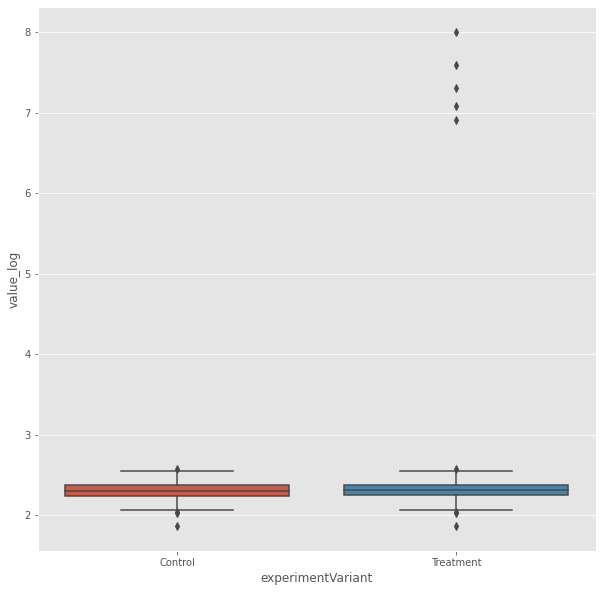

In [17]:
plt.figure(figsize=(10, 10))
ax = sns.boxplot(x="experimentVariant", y="value_log", data=data)

In [ ]:
# Построим график распределения выручки в контрольной группе

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


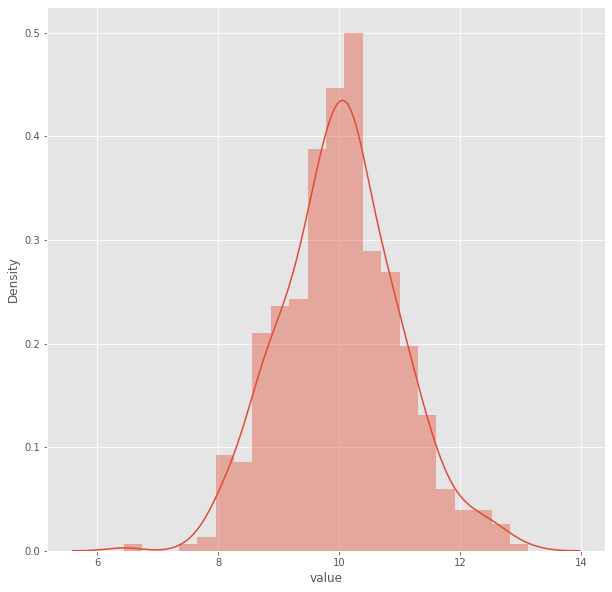

In [18]:
plt.figure(figsize=(10, 10))
sns.distplot(data[data.experimentVariant == 'Control'].value)

In [31]:
# Построим  график распределения выручки в тестовой группе

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


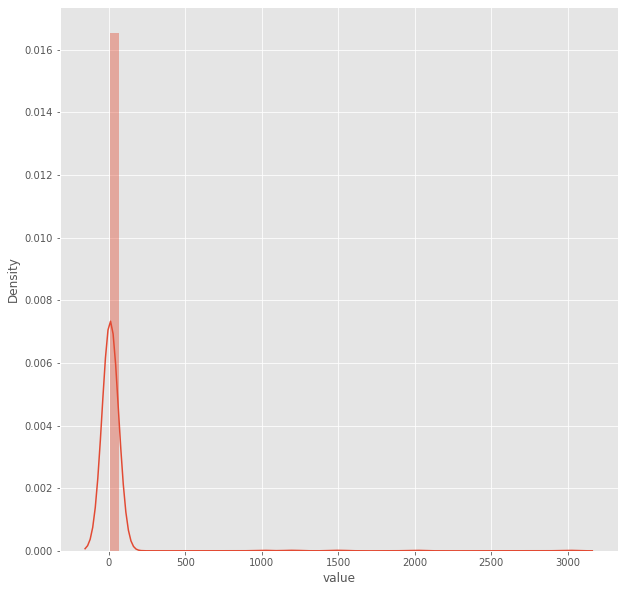

In [19]:
plt.figure(figsize=(10, 10))
sns.distplot(data[data.experimentVariant == 'Treatment'].value)

Как мы видим, распределение в контрольной группе является нормальным (Гауссовским), в тестовой группе близкое к экспоненциальному

Посчитаем p-value тремя способами: t-тест, U-тест, bootstrap средних

In [20]:
mannwhitneyu(data[data.experimentVariant == 'Treatment'].value, 
             data[data.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)


Нулевая гипотеза (H0) в тесте Манна_уитни утверждает, что нет статистически значимой разницы между средними значениями двух генеральных совокупностей. Альтернативная гипотеза (H1) утверждает, что существует статистически значимая разница между средними значениями двух генеральных совокупностей.

Для размера выборки n1=n2=500 и уровня значимости α= 0,05 критическое значение для теста Манна-Уитни можно посчитать с помощью таблицы критических значений, оно равняется 104500.

В нашем случае, статистика теста Манна-Уитни, рассчитанная для двух выборок размером 500 каждая, превышает 104500 и равняется 125810 , следовательно мы можем отклонить нулевую гипотезу на уровне значимости 0,05 и сделать вывод о статистически значимой разнице между средними значениями в контрольной и тестовых выборках.

In [21]:
ttest_ind(data[data.experimentVariant == 'Treatment'].value, 
             data[data.experimentVariant == 'Control'].value)

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.038437593613498765)

3) Bootstrap :

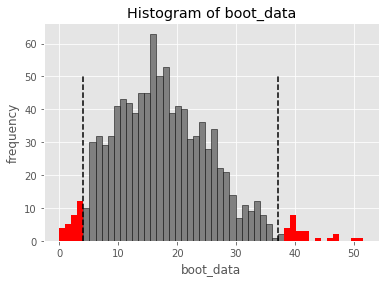

{'boot_data': [18.23952542388146,
  18.6060787221967,
  37.17436244749281,
  6.110783134815062,
  33.254903912559925,
  21.21008945637613,
  10.29721288249188,
  45.87359784835447,
  14.03410031100067,
  19.456093747437976,
  9.937644326374656,
  17.91908195892446,
  21.301203039464525,
  30.331309102963928,
  13.689920336106516,
  17.824201602488067,
  27.81011737007816,
  16.94357853682277,
  5.395314283843552,
  20.58701731218173,
  34.82233309807618,
  47.10110492930036,
  18.620270240406185,
  21.918569583737867,
  6.69717737647867,
  16.401731319035353,
  21.617208679701633,
  20.34040820074757,
  17.242748818568487,
  23.259632713589916,
  7.915649768630287,
  12.711065679051114,
  13.91579469888395,
  18.260989451271385,
  20.178704079568824,
  18.71326651287678,
  16.307957837907463,
  26.648917316033142,
  23.29221951299168,
  15.180132398227576,
  24.22981259261224,
  17.901076798068217,
  41.13960926170378,
  10.372408773449035,
  15.990329792973249,
  17.639019784165455,
 

In [22]:
get_bootstrap(
    data[data.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data[data.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

Нулевая гипотеза с использованием метода Bootstrap формируется следующим образом : в контрольной и тестовой группе   разница между средними значениями выборок равна нулю.
Мы видим на графике , что попали  в "хвост" распределения, где вероятность мала ( меньше 5%), значит можем отвергнуть нулевую гипотезу и принять альтернативную.


Давайте еще посмотрим на дисперсию в наших выборках и сделаем вывод, относительно метода, который лучше всего использовать в данной задаче

In [29]:
data[data.experimentVariant == 'Control'].value.var()

0.9591800678643451

In [30]:
data[data.experimentVariant == 'Treatment'].value.var()

34803.518450208336

Мы видим что дисперсии не равны, т.к данные в тестовой группе смещены . Поэтому в нашей задаче корректнее было бы оценивать признак медианы.
Используя ЦПТ мы не сможем построить доверительный интервал, поэтому обратимся к методу bootstrap,  который используется для оценки статистических характеристик, таких как среднее значение, медиана, дисперсия и корреляция, на основе выборки из данных.

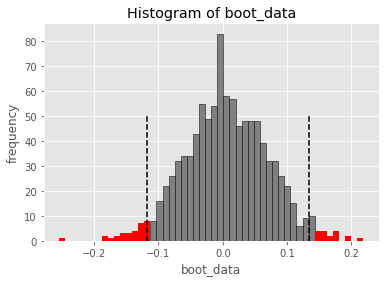

{'boot_data': [-0.06984142894305023,
  -0.03749769002820358,
  -0.01770247956410209,
  -0.12735653587546203,
  0.016831655340048712,
  -0.11279618650161538,
  -0.0033906274497983446,
  0.03839730698561361,
  0.011739815837850998,
  -0.0374024506156001,
  -0.017282071312850533,
  0.015717633612274184,
  0.12958281658649895,
  -0.05246209668362134,
  -0.0686807410189747,
  -0.04513065593430099,
  -0.09680723281295833,
  -0.03304502563370271,
  -0.06334427465770176,
  0.011290229477900482,
  -0.06285067485970153,
  -0.015625401106449388,
  0.05823176452553902,
  0.03483000016590232,
  0.02257744744700041,
  0.04135202109135072,
  0.01343739285772294,
  -0.03375060171100053,
  0.10391089027586986,
  0.0443961364337504,
  0.00453053347220056,
  -0.047180678952051025,
  0.0012012731465009807,
  0.08780890310390177,
  -0.08680046373484984,
  0.08243880035890072,
  -0.04123077976744938,
  0.03288544086815115,
  -0.025284544937649756,
  -0.004497427873747739,
  0.03593995601429967,
  0.01897421

In [23]:
get_bootstrap(
    data[data.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data[data.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

Мы можем сделать вывод, что на основе полученных данных, медиана признака не отличается от нуля с высокой степенью уверенности (доверительный интервал содержит ноль и p-value значительно превышает уровень значимости 0.05). Это означает, что мы не можем отвергнуть нулевую гипотезу о том, что медиана признака равна нулю.